In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src/")
import numpy as np
import pandas as pd

extracted_features_dir = "../data/extracted_features/"
results_dir = "../data/results/classification_library/"
sentiment_dir = "../data/evaluationscore/"
canonization_labels_dir = "../data/labels/"
lang = "ger"

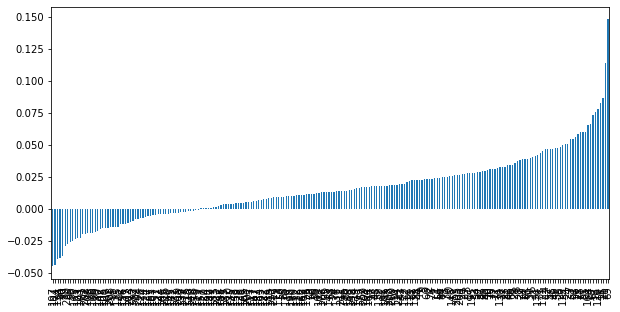

In [2]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.svm import SVR, SVC
import xgboost
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBRegressor
from copy import deepcopy
from scipy.stats import pearsonr
from utils import read_sentiment_scores, read_library_scores
from math import sqrt
get_ipython().run_line_magic("matplotlib", "inline") # %matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import heapq
import statistics
import random
random.seed(2)

labels = read_sentiment_scores(sentiment_dir, canonization_labels_dir, lang)
library_scores = read_library_scores(sentiment_dir, canonization_labels_dir, lang)
#labels = read_labels(canonization_labels_dir)

In [3]:
labels

,book_name,y,c
0,Alexis_Willibald_Der-falsche-Woldemar_1842,0.025530,3
1,Alexis_Willibald_Ruhe-ist-die-erste-Buergerpfl...,0.023794,3
2,Alexis_Willibald_Cabanis_1830,0.023481,3
3,Alexis_Willibald_Schloss-Avalon_1826,0.027773,3
4,Alexis_Willibald_Walladmor_1824,0.046649,3
...,...,...,...
133,Eichendorff_Joseph_Viel-Laermen-um-Nichts_1832,0.022402,2
142,Fontane_Theodor_Effi-Briest_1895,-0.015735,2
145,Fontane_Theodor_Die-Poppenpuhls_1896,-0.003428,2
178,Moerike_Eduard_Maler-Bolten_1836,0.016478,2


173


<AxesSubplot:ylabel='Frequency'>

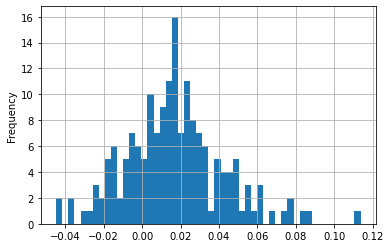

In [4]:
## Labels statistics
print(len(pd.unique(labels["book_name"]))) #197
# 254 labels, 197 different book_names -> 57 second/third... reviews
# 36 book_names with more than 1 label, these 36 book_names have 93 labels
# 93 = 36 first reviews + 57 second/third... reviews
# 6 texts have opposing reviews (13 reviews are opposing)
# 191 texts after aggregating (without opposing reviews)

labels["y"].plot.hist(grid=True, bins=50)

In [5]:
'''
Fehler
Brooke_Frances_Emily_Montague_1769
Lennox_Charlotte_The-Female_Quixote_1752
Stoker_Bram-Dracula_1897

Nicolai_Friedrich_Sebaldus-Nothanker-1773
Jung-Stilling_Heinrich-Stillings-Jugend_1777
Sacher-Masoch_Venus-im-Pelz_1869
Hunold_Christian_Friedrich_Die-liebenswuerdige-Adalie_1681

Hoffmansthal_Hugo ['Hoffmansthal_Hugo_Andreas-oder-die-Vereinigten_1907', 'Hoffmansthal_Hugo_Das-Maerchen-der-672-Nacht_1895'] 
Hoffmansthal_Hugo-von ['Hoffmansthal_Hugo-von_Ein-Brief_1902', 'Hoffmansthal_Hugo-von_Reitergeschichte_1899'] 


Anonymous anonymous??

df = df.loc[df["book_name"] != "Defoe_Daniel_Roxana_1724"]


'''

'\nFehler\nBrooke_Frances_Emily_Montague_1769\nLennox_Charlotte_The-Female_Quixote_1752\nStoker_Bram-Dracula_1897\n\nNicolai_Friedrich_Sebaldus-Nothanker-1773\nJung-Stilling_Heinrich-Stillings-Jugend_1777\nSacher-Masoch_Venus-im-Pelz_1869\nHunold_Christian_Friedrich_Die-liebenswuerdige-Adalie_1681\n\nHoffmansthal_Hugo [\'Hoffmansthal_Hugo_Andreas-oder-die-Vereinigten_1907\', \'Hoffmansthal_Hugo_Das-Maerchen-der-672-Nacht_1895\'] \nHoffmansthal_Hugo-von [\'Hoffmansthal_Hugo-von_Ein-Brief_1902\', \'Hoffmansthal_Hugo-von_Reitergeschichte_1899\'] \n\n\nAnonymous anonymous??\n\ndf = df.loc[df["book_name"] != "Defoe_Daniel_Roxana_1724"]\n\n\n'

In [6]:
class AuthorSplit():
    """
    Distribute book names over splits.
    All works of an author are in the same split.
    Adapted from https://www.titanwolf.org/Network/q/b7ee732a-7c92-4416-bc80-a2bd2ed136f1/y
    Stevenson-Grift_Robert-Louis-Fanny-van-de_The-Dynamiter_1885

    """
    def __init__(self, df, nr_splits, seed, return_indices=False):
        self.df = df
        self.nr_splits = nr_splits
        self.return_indices = return_indices
        self.book_names = df["book_name"].unique()
        self.author_bookname_mapping, self.works_per_author = self.get_author_books()
        random.seed(seed)

    def get_author_books(self):
        authors = []
        author_bookname_mapping = {}
        #Get authors
        for book_name in self.book_names:
            author = "_".join(book_name.split("_")[:2])
            authors.append(author)
            if author in author_bookname_mapping:
                author_bookname_mapping[author].append(book_name)
            else:
                author_bookname_mapping[author] = []
                author_bookname_mapping[author].append(book_name)
                
        # Aggregate if author has worked anlone and with others
        if lang == "ger":
            agg_dict = {"Hoffmansthal_Hugo": ["Hoffmansthal_Hugo-von"], 
                        "Schlaf_Johannes": ["Holz-Schlaf_Arno-Johannes"],
                         "Arnim_Bettina": ["Arnim-Arnim_Bettina-Gisela"]}
        else:
            agg_dict = {"Stevenson_Robert-Louis": ["Stevenson-Grift_Robert-Louis-Fanny-van-de", 
                                                   "Stevenson-Osbourne_Robert-Louis-Lloyde"]}
            
        print(authors)
        for author, aliases in agg_dict.items():
            if author in authors:
                print(author, aliases)
                for alias in aliases:
                    print(alias)
                    author_bookname_mapping[author].extend(author_bookname_mapping[alias]) 
                    del author_bookname_mapping[alias]
                    authors = [author for author in authors if author != alias]
        
        works_per_author = Counter(authors)
        return author_bookname_mapping, works_per_author
    
    def split(self):
        splits = [[] for _ in range(0,self.nr_splits)]
        totals = [(0,i) for i in range (0, self.nr_splits)]
        # heapify based on first element of tuple, inplace
        heapq.heapify(totals)
        while bool(self.works_per_author):
            author = random.choice(list(self.works_per_author.keys()))
            author_workcount = self.works_per_author.pop(author)
            # find split with smallest number of books
            total, index = heapq.heappop(totals)
            splits[index].append(author)
            heapq.heappush(totals, (total + author_workcount, index))

        if not self.return_indices:
            #Map author splits to book names
            map_splits = []
            for split in splits:
                new = []
                for author in split:
                    new.extend(self.author_bookname_mapping[author])
                map_splits.append(new)
        else:
            book_name_idx_mapping = dict((book_name, index) for index, book_name in enumerate(self.book_names))
            map_splits = []
            for split in splits:
                test_split = []
                for author in split:
                    test_split.extend([book_name_idx_mapping[book_name] for book_name in  self.author_bookname_mapping[author]])
                train_split = list(set(book_name_idx_mapping.values()) - set(test_split))
                map_splits.append((train_split, test_split))
        return map_splits

# lang="ger"
# df = pd.read_csv('/home/annina/scripts/great_unread_nlp/data/extracted_features/ger/book_df.csv')
# a = AuthorSplit(df, 6).split()
# a

In [7]:
class Regression():
    def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
        assert isinstance(drop_columns_including, list)
        for i in drop_columns_including:
            assert isinstance(i, str)
        assert (dimensionality_reduction in ["k_best_f_reg_0_10", "k_best_mutual_info_0_10", "ss_pca_0_95"]) or (dimensionality_reduction is None)
        self._check_class_specific_assertions()
        
        self.language = language
        self.features = features
        self.labels = labels
        self.labels = self._prepare_labels()
        self.drop_columns_including = drop_columns_including
        self.dimensionality_reduction = dimensionality_reduction
        self.model_param = model_param
        self.model = model
        self.verbose = verbose

        if self.features == "book":
            self.df = deepcopy(book_df)
        elif self.features == "chunk":
            self.df = deepcopy(chunk_df)
        elif self.features == "chunk_and_copied_book":
            self.df = deepcopy(chunk_and_copied_book_df)
        elif self.features == "book_and_averaged_chunk":
            self.df = deepcopy(book_and_averaged_chunk_df)

        columns_before_drop = set(self.df.columns)
        if self.drop_columns_including:
            self.df = self.df[[column for column in self.df.columns if not self._drop_column(column)]].reset_index(drop=True)
        columns_after_drop = set(self.df.columns)
        if self.verbose:
            print(f"Dropped {len(columns_before_drop - columns_after_drop)} columns.")
            
    def _check_class_specific_assertions(self):
        assert model in ["xgboost", "svr", "lasso"]
        assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
    
    def _prepare_labels(self):
        return self.labels.drop(columns="c")

    def _drop_column(self, column):
        for string in self.drop_columns_including:
            if string in column:
                return True
        return False
    
    def _custom_pca(self, train_X):
        for i in range(5, train_X.shape[1], int((train_X.shape[1] - 5) / 10)):
            pca = PCA(n_components=i)
            new_train_X = pca.fit_transform(train_X)
            if pca.explained_variance_ratio_.sum() >= 0.95:
                break
        return new_train_X, pca

    def _select_features(self, train_X, train_y, validation_X):
        if self.dimensionality_reduction == "ss_pca_0_95":
            ss = StandardScaler()
            train_X = ss.fit_transform(train_X)
            validation_X = ss.transform(validation_X)
            train_X, pca = self._custom_pca(train_X)
            validation_X = pca.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_f_reg_0_10":
            k_best = SelectKBest(f_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction == "k_best_mutual_info_0_10":
            k_best = SelectKBest(mutual_info_regression, k=np.minimum(int(0.10 * train_X.shape[0]), train_X.shape[1]))
            train_X = k_best.fit_transform(train_X, train_y)
            validation_X = k_best.transform(validation_X)
        elif self.dimensionality_reduction is None:
            pass
        return train_X, validation_X
    
    def _impute(self, train_X, validation_X):
        imputer = KNNImputer()
        train_X = imputer.fit_transform(train_X)
        validation_X = imputer.transform(validation_X)
        return train_X, validation_X
    
    def _get_model(self, model_param, train_X=None, train_y=None, train_book_names=None, task_type=None):
        if self.model == "xgboost":
            if task_type == "binary_classification":
                is_classification = True
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1], y=train_y.astype(int).tolist())))
            elif task_type == "multiclass_classification":
                is_classification = True
                class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1, 2, 3], y=train_y.astype(int).tolist())))
            elif task_type == "regression":
                is_classification = False
            else:
                raise Exception("Not a valid task_type")
            
            def feval(preds, train_data):
                labels = train_data.get_label()
                if is_classification:
                    labels = labels.astype(int)
                    preds = preds.argmax(axis=1).astype(int)
                    if task_type == "binary_classification":
                        return 'acc', accuracy_score(labels, preds)
                    elif task_type == "multiclass_classification":
                        return 'f1', f1_score(labels, preds, average='macro')
                else:
                    return 'rmse', np.sqrt(mean_squared_error(labels, preds))
            
            if is_classification:
                dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
            else:
                dtrain = xgboost.DMatrix(train_X, label=train_y)
            results = []
            df = np.hstack((train_book_names, train_X))
            df = pd.DataFrame(df, columns=["book_name"] + [f"col_{i}" for i in range(train_X.shape[1])])
            for max_depth in [2, 4, 6, 8]:
                for learning_rate in [None, 0.01, 0.033, 0.1]:
                    for colsample_bytree in [0.33, 0.60, 0.75]:
                        if task_type == "multiclass_classification":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1, "objective": "multi:softmax", "num_class": 4, "eval_metric": "mlogloss"}
                        elif task_type == "binary_classification":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1, "objective": "multi:softmax", "num_class": 2, "eval_metric": "mlogloss"}
                        elif task_type == "regression":
                            params = {"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "n_jobs": -1}
                        else:
                            raise Exception("Not a valid task_type")
                        cv_results = xgboost.cv(
                                        params,
                                        dtrain,
                                        num_boost_round=99999,
                                        seed=42,
                                        nfold=5,
                                        folds=AuthorSplit(df, 5, seed=8, return_indices=True).split(),
                                        feval=feval,
                                        maximize=is_classification, # if classification, maximize f1/acc score.
                                        early_stopping_rounds=10,
                                        verbose_eval=False)

                        if task_type == "binary_classification":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-acc-mean"]
                        elif task_type == "multiclass_classification":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-f1-mean"]
                        elif task_type == "regression":
                            nested_cv_score = cv_results.iloc[len(cv_results)-1]["test-rmse-mean"]
                        else:
                            raise Exception("Not a valid task_type")
                        num_boost_round = len(cv_results)
                        if task_type == "multiclass_classification":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score, "objective": "multi:softmax", "num_class": 4, "eval_metric": "mlogloss"})
                        elif task_type == "binary_classification":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score, "objective": "multi:softmax", "num_class": 2, "eval_metric": "mlogloss"})
                        elif task_type == "regression":
                            results.append({"max_depth": max_depth, "learning_rate": learning_rate, "colsample_bytree": colsample_bytree, "num_boost_round": num_boost_round, "nested_cv_score": nested_cv_score})
                        else:
                            raise Exception("Not a valid task_type")
            best_parameters = sorted(results, key=lambda x: x["nested_cv_score"], reverse=is_classification)[0]
            return best_parameters
        elif self.model == "svr":
            return SVR(C=model_param)
        elif self.model == "lasso":
            return Lasso(alpha=model_param)
        elif self.model == "svc":
            return SVC(C=model_param, class_weight="balanced")
        
    
    def _get_pvalue(self, validation_corr_pvalues):
        # Harmonic mean p-value
        denominator = sum([1/x for x in validation_corr_pvalues])
        mean_p_value = len(validation_corr_pvalues)/denominator
        return mean_p_value
    
    def _combine_df_labels(self, df):
        #Average of sentiscores per book
        df = df.merge(right=self.labels, on="book_name", how="inner", validate="many_to_one")
        return df
    
    def run(self):
        all_predictions = []
        all_labels = []

        train_mses = []
        train_maes = []
        train_r2s = []
        train_corrs = []
        
        validation_mses = []
        validation_maes = []
        validation_r2s = []
        validation_corrs = []
        validation_corr_pvalues = []

        df = self.df
        df = self._combine_df_labels(df)
        book_names_split = AuthorSplit(df, 5, seed=2, return_indices=False).split() ## 10 folds
        all_validation_books = []

        for index, split in enumerate(book_names_split):
            train_df = df[~df["book_name"].isin(split)]
            validation_df = df[df["book_name"].isin(split)]
            
            train_X = train_df.drop(columns=["y", "book_name"]).values
            train_y = train_df["y"].values.ravel()
            validation_X = validation_df.drop(columns=["y", "book_name"]).values
            validation_y = validation_df["y"].values.ravel()
            train_X, validation_X = self._impute(train_X, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
            train_X, validation_X = self._select_features(train_X, train_y, validation_X)
            #if self.verbose:
            #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
            if self.model == "xgboost":
                train_book_names = train_df["book_name"].values.reshape(-1, 1)
                best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="regression")
                dtrain = xgboost.DMatrix(train_X, label=train_y)
                num_boost_round = best_parameters["num_boost_round"]
                best_parameters.pop("nested_cv_score")
                best_parameters.pop("num_boost_round")
                model = xgboost.train(best_parameters,
                                      dtrain,
                                      num_boost_round=num_boost_round,
                                      verbose_eval=False)
            else:
                model = self._get_model(self.model_param)
                model.fit(train_X, train_y)
            
            train_books = deepcopy(train_df[["book_name", "y"]])
            validation_books = deepcopy(validation_df[["book_name", "y"]])
            
            if self.model == "xgboost":
                train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
                validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
                
                print("train preds:", model.predict(xgboost.DMatrix(train_X)))
                print("validation preds:", model.predict(xgboost.DMatrix(validation_X)))
            else:
                train_books["yhat"] = model.predict(train_X)
                validation_books["yhat"] = model.predict(validation_X)
            
            train_books = train_books.groupby("book_name").mean()
            validation_books = validation_books.groupby("book_name").mean()
            all_validation_books.append(validation_books.reset_index())
            
            train_y = train_books["y"].tolist()
            train_yhat = train_books["yhat"].tolist()
            validation_y = validation_books["y"].tolist()
            validation_yhat = validation_books["yhat"].tolist()
            
            all_labels.extend(validation_y)
            all_predictions.extend(validation_yhat)
            
            train_mse = mean_squared_error(train_y, train_yhat)
            train_mae = mean_absolute_error(train_y, train_yhat)
            train_r2 = r2_score(train_y, train_yhat)
            train_corr = pearsonr(train_y, train_yhat)[0]
            
            validation_mse = mean_squared_error(validation_y, validation_yhat)
            validation_mae = mean_absolute_error(validation_y, validation_yhat)
            validation_r2 = r2_score(validation_y, validation_yhat)
            validation_corr = pearsonr(validation_y, validation_yhat)[0]
            p_value = pearsonr(validation_y, validation_yhat)[1]
            
            train_mses.append(train_mse)
            train_maes.append(train_mae)
            train_r2s.append(train_r2)
            train_corrs.append(train_corr)
            
            validation_mses.append(validation_mse)
            validation_maes.append(validation_mae)
            validation_r2s.append(validation_r2)
            validation_corrs.append(validation_corr)
            validation_corr_pvalues.append(p_value)
            
            if self.verbose:
                print(f"Fold: {index+1}, TrainMSE: {np.round(train_mse, 3)}, TrainMAE: {np.round(train_mae, 3)}, ValMSE: {np.round(validation_mse, 3)}, ValMAE: {np.round(validation_mae, 3)}, ValR2: {np.round(validation_r2, 3)}, ValCorr: {np.round(validation_corr, 3)}")
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)
        
        # Save y and y_pred for examples
        #pd.concat(all_validation_books).to_csv(results_dir + "/y-yhat-" + param_dir + '_' + self.language + "-" + ".csv", index=False)
        
        mean_train_mse = np.mean(train_mses)
        mean_train_rmse = np.mean([sqrt(x) for x in train_mses])
        mean_train_mae = np.mean(train_maes)
        mean_train_r2 = np.mean(train_r2s)
        mean_train_corr = np.mean(train_corrs)
        
        mean_validation_mse = np.mean(validation_mses)
        mean_validation_rmse = np.mean([sqrt(x) for x in validation_mses])
        mean_validation_mae = np.mean(validation_maes)
        mean_validation_r2 = np.mean(validation_r2s)
        mean_validation_corr = np.mean(validation_corrs)
        mean_p_value = self._get_pvalue(validation_corr_pvalues)
        
        if self.verbose:
            print(f"""TrainMSE: {np.round(mean_train_mse, 3)}, TrainRMSE: {np.round(mean_train_rmse, 3)}, TrainMAE: {np.round(mean_train_mae, 3)}, TrainR2: {np.round(mean_train_r2, 3)}, TrainCorr: {np.round(mean_train_corr, 3)}, ValMSE: {np.round(mean_validation_mse, 3)}, ValRMSE: {np.round(mean_validation_rmse, 3)}, ValMAE: {np.round(mean_validation_mae, 3)}, ValR2: {np.round(mean_validation_r2, 3)}, ValCorr: {np.round(mean_validation_corr, 3)}, ValCorrPValue: {np.round(mean_p_value, 3)}""")
            print("\n---------------------------------------------------\n")
            plt.figure(figsize=(4,4))
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.xlim([0,1])
            plt.ylim([0,1])

            plt.scatter(all_labels, all_predictions, s=6)
            plt.xlabel("Canonization Scores", fontsize=20)
            plt.ylabel("Predicted Scores", fontsize=20)
            plt.savefig(results_dir + lang + "-" + self.model + "-" + str(self.dimensionality_reduction) 
            + "-" + self.features + "-" + "-" + "param" + str(self.model_param) + "-" + ".png", 
            dpi=400, bbox_inches="tight")
    
            plt.show();
        return mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value

In [8]:
### Cross-validation

# Feature split
complexity_features = []

# All parameters
models = ["svr", "lasso", "xgboost", "svc"]
model_params = {"svr": [1], "lasso": [1, 4], "xgboost": [None], "svc": [0.1, 1, 10, 100, 1000, 10000]} #
dimensionality_reduction = ["ss_pca_0_95", 'k_best_f_reg_0_10', 'k_best_mutual_info_0_10', [None]]
features = ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]

# Which parameters to use
regression_params = {"model": ["xgboost"], "dimensionality_reduction": dimensionality_reduction[-1], "features": [features[0]]}
testing_params = {"model": models[3], "dimensionality_reduction": dimensionality_reduction[-1], 
                  "features": ["book"]}
twoclass_params = {"model": ["svc", "xgboost"], "dimensionality_reduction": dimensionality_reduction[-1], 
                  "features": ["book", "book_and_averaged_chunk"]}
multiclass_params = {"model": ["svc", "xgboost"], "dimensionality_reduction": dimensionality_reduction[-1],
                     "features": ["book", "book_and_averaged_chunk"]}
library_params = {"model": ["svc", "xgboost"], "dimensionality_reduction": dimensionality_reduction[-1], 
                  "features": ["book", "book_and_averaged_chunk"]}

In [9]:
'''
Run Regression
'''
results = []
param_dict = "regression" 
for lang in [lang]:
    if param_dict == "regression":
        param_dir = regression_params
    if param_dict == "testing":
        param_dir = testing_params
    elif param_dict == "multiclass":
        param_dir = multiclass_params
    elif param_dict == "full_cv":
        param_dir = full_cv_params
    
    #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
    book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
    book_df["book_name"].to_csv('nametest')
    book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
    chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
    chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")

    for model in param_dir['model']:
        model_param = model_params[model]
        for model_param in model_param:
            for dimensionality_reduction in param_dir["dimensionality_reduction"]:
                for features in param_dir["features"]:
                    for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
                                                   ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
                        print(param_dict, lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param)
                        experiment = Regression(
                            language=lang,
                            features=features,
                            drop_columns_including=drop_columns_including,
                            dimensionality_reduction = dimensionality_reduction,
                            model_param=model_param,
                            model=model,
                            verbose=True
                        )
                        experiment.run()
                        #mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value = experiment.run()
                        #results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_mse, mean_train_rmse, mean_train_mae, mean_train_r2, mean_train_corr, mean_validation_mse, mean_validation_rmse, mean_validation_mae, mean_validation_r2, mean_validation_corr, mean_p_value))
                        #except Exception as e:
#                             print(f"Error in {lang}, {model}, {features}, {drop_columns_including}, {dimensionality_reduction}")
#                             print(e)
#results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
# "dimensionality_reduction", "model_param", "mean_train_mse", "mean_train_rmse", 
# "mean_train_mae", "mean_train_r2", "mean_train_corr", "mean_validation_mse", "mean_validation_rmse",
# "mean_validation_mae", "mean_validation_r2", "mean_validation_corr", "mean_p_value"])
#results_df.to_csv(results_dir + lang + '_' + 'regression_' + param_dict + ".csv", index=False    

regression ger xgboost book ['average_sentence_embedding', '100_most_common_', 'doc2vec_chunk_embedding'] None param= None
Dropped 300 columns.
['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Kleist_Heinrich', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Ludwig_Otto', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Saar_F

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Saar_Ferdinand', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Alexis_Willibald', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eich

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Saar_Ferdinand', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Alexis_Willibald', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eich

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Saar_Ferdinand', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Alexis_Willibald', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eich

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Saar_Ferdinand', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Alexis_Willibald', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eich

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Saar_Ferdinand', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Alexis_Willibald', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eich

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Saar_Ferdinand', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Alexis_Willibald', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eich

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Saar_Ferdinand', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Alexis_Willibald', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eich

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Saar_Ferdinand', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Alexis_Willibald', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eich

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Saar_Ferdinand', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Alexis_Willibald', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eich

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Saar_Ferdinand', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Alexis_Willibald', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eich

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Saar_Ferdinand', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Alexis_Willibald', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eich

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Saar_Ferdinand', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Alexis_Willibald', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eich

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Saar_Ferdinand', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Alexis_Willibald', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eich

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Saar_Ferdinand', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Alexis_Willibald', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eich

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Saar_Ferdinand', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Alexis_Willibald', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eich

train preds: [ 0.02081609  0.02295409 -0.02241004  0.00412569 -0.00752064  0.004647
  0.06047068  0.01763644  0.0277521  -0.01694627 -0.01433599  0.00395484
  0.0409826   0.00406317  0.0546151   0.03412329  0.04666732  0.01947435
  0.0237992   0.00494958  0.02724205 -0.03627644  0.00917708  0.00775084
 -0.00680837  0.00275832  0.0266471   0.02418797  0.02353874  0.06671134
 -0.00283622  0.11314582  0.01742986  0.02737518  0.05834616  0.0165876
  0.04989235 -0.02346233  0.0075937  -0.01533209 -0.01872743  0.01818942
  0.01337175  0.01789945  0.00557631  0.0321043   0.08184268  0.02341667
  0.01063473  0.04377014  0.01440092  0.02685625  0.02480225 -0.00112019
  0.03946538  0.04815952  0.01744627  0.03260956 -0.04289227  0.01612013
  0.00886136  0.03114772  0.01373773  0.0006856   0.00652004 -0.0437154
  0.01441501  0.01962026 -0.0139376  -0.00134123  0.03897205  0.01196769
  0.05593816  0.04619194 -0.00691465  0.03728377  0.01714182  0.01113004
 -0.01830852 -0.0011092   0.0229574  -0.00

['Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Kleist_Heinrich', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Boehlau_Helene', 'Ebers_George', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Ludwig_Otto', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Ebner-Eschenbach_Marie', 'Saar_Ferdinand', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Eichendorff_Joseph', 'Klinger_Friedrich', 'Alexis_Willibald', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph', 'Wienbarg_Ludolph', 'Tieck_Ludwig', 'Ebner-Eschenbach_Marie

['Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Kleist_Heinrich', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Boehlau_Helene', 'Ebers_George', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Ludwig_Otto', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Ebner-Eschenbach_Marie', 'Saar_Ferdinand', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Eichendorff_Joseph', 'Klinger_Friedrich', 'Alexis_Willibald', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph', 'Wienbarg_Ludolph', 'Tieck_Ludwig', 'Ebner-Eschenbach_Marie

['Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Kleist_Heinrich', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Boehlau_Helene', 'Ebers_George', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Ludwig_Otto', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Ebner-Eschenbach_Marie', 'Saar_Ferdinand', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Eichendorff_Joseph', 'Klinger_Friedrich', 'Alexis_Willibald', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph', 'Wienbarg_Ludolph', 'Tieck_Ludwig', 'Ebner-Eschenbach_Marie

['Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Kleist_Heinrich', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Boehlau_Helene', 'Ebers_George', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Ludwig_Otto', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Ebner-Eschenbach_Marie', 'Saar_Ferdinand', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Eichendorff_Joseph', 'Klinger_Friedrich', 'Alexis_Willibald', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph', 'Wienbarg_Ludolph', 'Tieck_Ludwig', 'Ebner-Eschenbach_Marie

['Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Kleist_Heinrich', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Boehlau_Helene', 'Ebers_George', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Ludwig_Otto', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Ebner-Eschenbach_Marie', 'Saar_Ferdinand', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Eichendorff_Joseph', 'Klinger_Friedrich', 'Alexis_Willibald', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph', 'Wienbarg_Ludolph', 'Tieck_Ludwig', 'Ebner-Eschenbach_Marie

['Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Kleist_Heinrich', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Boehlau_Helene', 'Ebers_George', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Ludwig_Otto', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Ebner-Eschenbach_Marie', 'Saar_Ferdinand', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Eichendorff_Joseph', 'Klinger_Friedrich', 'Alexis_Willibald', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph', 'Wienbarg_Ludolph', 'Tieck_Ludwig', 'Ebner-Eschenbach_Marie

['Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Kleist_Heinrich', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Boehlau_Helene', 'Ebers_George', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Ludwig_Otto', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Ebner-Eschenbach_Marie', 'Saar_Ferdinand', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Eichendorff_Joseph', 'Klinger_Friedrich', 'Alexis_Willibald', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph', 'Wienbarg_Ludolph', 'Tieck_Ludwig', 'Ebner-Eschenbach_Marie

['Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Kleist_Heinrich', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Boehlau_Helene', 'Ebers_George', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Ludwig_Otto', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Ebner-Eschenbach_Marie', 'Saar_Ferdinand', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Eichendorff_Joseph', 'Klinger_Friedrich', 'Alexis_Willibald', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph', 'Wienbarg_Ludolph', 'Tieck_Ludwig', 'Ebner-Eschenbach_Marie

['Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Kleist_Heinrich', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Boehlau_Helene', 'Ebers_George', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Ludwig_Otto', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Ebner-Eschenbach_Marie', 'Saar_Ferdinand', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Eichendorff_Joseph', 'Klinger_Friedrich', 'Alexis_Willibald', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph', 'Wienbarg_Ludolph', 'Tieck_Ludwig', 'Ebner-Eschenbach_Marie

['Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Kleist_Heinrich', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Boehlau_Helene', 'Ebers_George', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Ludwig_Otto', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Ebner-Eschenbach_Marie', 'Saar_Ferdinand', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Eichendorff_Joseph', 'Klinger_Friedrich', 'Alexis_Willibald', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph', 'Wienbarg_Ludolph', 'Tieck_Ludwig', 'Ebner-Eschenbach_Marie

['Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Kleist_Heinrich', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Boehlau_Helene', 'Ebers_George', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Ludwig_Otto', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Ebner-Eschenbach_Marie', 'Saar_Ferdinand', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Eichendorff_Joseph', 'Klinger_Friedrich', 'Alexis_Willibald', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph', 'Wienbarg_Ludolph', 'Tieck_Ludwig', 'Ebner-Eschenbach_Marie

['Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Kleist_Heinrich', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Boehlau_Helene', 'Ebers_George', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Ludwig_Otto', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Ebner-Eschenbach_Marie', 'Saar_Ferdinand', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Eichendorff_Joseph', 'Klinger_Friedrich', 'Alexis_Willibald', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph', 'Wienbarg_Ludolph', 'Tieck_Ludwig', 'Ebner-Eschenbach_Marie

['Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Kleist_Heinrich', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Boehlau_Helene', 'Ebers_George', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Ludwig_Otto', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Ebner-Eschenbach_Marie', 'Saar_Ferdinand', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Eichendorff_Joseph', 'Klinger_Friedrich', 'Alexis_Willibald', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph', 'Wienbarg_Ludolph', 'Tieck_Ludwig', 'Ebner-Eschenbach_Marie

['Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Kleist_Heinrich', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Boehlau_Helene', 'Ebers_George', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Ludwig_Otto', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Ebner-Eschenbach_Marie', 'Saar_Ferdinand', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Eichendorff_Joseph', 'Klinger_Friedrich', 'Alexis_Willibald', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph', 'Wienbarg_Ludolph', 'Tieck_Ludwig', 'Ebner-Eschenbach_Marie

['Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Kleist_Heinrich', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Boehlau_Helene', 'Ebers_George', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Ludwig_Otto', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Ebner-Eschenbach_Marie', 'Saar_Ferdinand', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Eichendorff_Joseph', 'Klinger_Friedrich', 'Alexis_Willibald', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph', 'Wienbarg_Ludolph', 'Tieck_Ludwig', 'Ebner-Eschenbach_Marie

['Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Kleist_Heinrich', 'Ehrmann_Marianne', 'Mereau_Sophie', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Saar_Ferdinand', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Hoelderlin_Friedrich', 'Alexis_Willibald', 'Fontane_Theodor', 'Zschokke_Johann', 'Boehlau_Helene', 'Ebers_George', 'Storm_Theodor', 'Gerstaecker_Friedrich', 'Ludwig_Otto', 'Brentano_Clemens', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Saar_Ferdinand', 'Brentano_Clemens', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Ebner-Eschenbach_Marie', 'Saar_Ferdinand', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Eichendorff_Joseph', 'Klinger_Friedrich', 'Alexis_Willibald', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph', 'Wienbarg_Ludolph', 'Tieck_Ludwig', 'Ebner-Eschenbach_Marie

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Kleist_Heinrich', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Fontane_Theodor', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Ludwig_Otto', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Ebner-Eschenbach_Marie', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Klinger_Friedrich', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Kleist_Heinrich', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Fontane_Theodor', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Ludwig_Otto', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Ebner-Eschenbach_Marie', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Klinger_Friedrich', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Kleist_Heinrich', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Fontane_Theodor', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Ludwig_Otto', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Ebner-Eschenbach_Marie', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Klinger_Friedrich', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Kleist_Heinrich', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Fontane_Theodor', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Ludwig_Otto', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Ebner-Eschenbach_Marie', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Klinger_Friedrich', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Kleist_Heinrich', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Fontane_Theodor', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Ludwig_Otto', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Ebner-Eschenbach_Marie', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Klinger_Friedrich', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph

['Mundt_Theodor', 'Polenz_Wilhelm-von', 'Ebner-Eschenbach_Marie', 'Frenssen_Gustav', 'Hoffmann_ETA', 'Fontane_Theodor', 'Hippel_Theodor-Gottlieb', 'Kleist_Heinrich', 'Ebner-Eschenbach_Marie', 'Kurz_Hermann', 'Moerike_Eduard', 'Gutzkow_Karl', 'Storm_Theodor', 'Aston_Louise', 'Meyer_Conrad-Ferdinand', 'Motte-Fouque_Caroline', 'Keller_Gottfried', 'Meyer_Conrad-Ferdinand', 'Raabe_Wilhelm', 'Raabe_Wilhelm', 'Fontane_Theodor', 'Gutzkow_Karl', 'Boehlau_Helene', 'Ebers_George', 'Kretzer_Max', 'Storm_Theodor', 'Ludwig_Otto', 'Spielhagen_Friedrich', 'Anzengruber_Ludwig', 'Otto-Peters_Louise', 'Muegge_Theodor', 'Eichendorff_Joseph', 'Moerike_Eduard', 'Hauff_Wilhelm', 'Chamisso_Adalbert', 'Gotthelf_Jeremias', 'Hoffmann_ETA', 'Fontane_Theodor', 'Stifter_Adalbert', 'Ebner-Eschenbach_Marie', 'Raabe_Wilhelm', 'Rank_Josef', 'Auerbach_Berthold', 'Stifter_Adalbert', 'Eichendorff_Joseph', 'Dohm_Hedwig', 'Klinger_Friedrich', 'Franzos_Karl-Emil', 'Gutzkow_Karl', 'Scheffel_Joseph-Victor', 'Eichendorff_Joseph

KeyboardInterrupt: 

In [ ]:
# '''
# Classification into reviewed/not reviewed
# '''

# class TwoclassClassification(Regression):
#     def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
#         super().__init__(language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose)

#     def _check_class_specific_assertions(self):
#         assert model in ["svc", "xgboost"]
#         assert features in ["book", "chunk", "book_and_averaged_chunk", "chunk_and_copied_book"]
        
#     def _prepare_labels(self):
#         labels = self.labels.drop(columns="y").rename(columns={"c":"y"})
#         return labels
        
#     def _combine_df_labels(self, df):
#         #Reviews zum englischen Korpus beginnnen mit 1759 und decken alles bis 1914 ab
#         agg_labels = self.labels[["book_name"]].drop_duplicates()
#         agg_labels["y"] = 1
#         df = df.merge(right=agg_labels, on="book_name", how="left", validate="many_to_one")
#         df["y"] = df["y"].fillna(value=0)
#         #Select books written after year of first review)
#         year = df["book_name"].str.replace('-', '_').str.split('_').str[-1].astype('int64')
#         df = df.loc[year>=min(year)]
#         return df
    
#     def _get_sample_weights(self, df):
#         # Weights for calculating accuracy 
#         chunks_per_book = df["book_name"].value_counts(sort=False).rename('chunks_per_book')
#         chunks_per_book = chunks_per_book.reset_index().rename(columns={"index":'book_name'})
#         chunks_per_book["chunks_per_book"] = 1/chunks_per_book["chunks_per_book"]
#         df = df.merge(right=chunks_per_book, how="left", on="book_name")
#         sample_weights = df["chunks_per_book"].tolist()
#         return sample_weights
    
#     def _aggregate_chunk_predictions(self, df):
#         g = df.groupby("book_name")
        
#         # Majority vote
#         # If one value is more common, assign it to every chunk
#         # Therefore, accuracy is either 0 or 1
#         # If both values are equally likely, leave them unchanged, and accuracy is 0.5
#         def _get_mode_accuracy(group):
#             counts = group["yhat"].value_counts()
#             if len(counts) == 1:
#                 mode_acc = counts.index[0]
#             else:
#                 mode_acc = 0.5
#             return mode_acc
#         mode_accs = g.apply(_get_mode_accuracy).rename("mode_acc").reset_index()
#         mode_acc = mode_accs["mode_acc"].mean()
        
#         # Average accuracy within book
#         book_acc = g.apply(lambda group: accuracy_score(group["y"], group["yhat"])).mean()
#         #Accuracy when each chunk is treated as single document
#         chunk_acc = accuracy_score(df["y"], df["yhat"])#, sample_weight = self._get_sample_weights(df))
#         return {"mode_acc": mode_acc, "book_acc": book_acc, "chunk_acc": chunk_acc}
    
#     def _split_booknames_stratified(self, df, nr_splits, return_indices=False):
#         label_splits = []
#         combined_splits = []
#         # Split df into folds for each label individualls
#         df_by_labels = df.groupby("y")
#         for name, group in df_by_labels:
#             split = self._split_booknames(group, 5)
#             label_splits.append(split)
#         # Combine splits so that one split combines splits of all labels
#         for fold in range(0, nr_splits):
#             combined_split = []
#             for label in range(0, len(pd.unique(df["y"]))):
#                 label_split = label_splits[label]
#                 fold_split = label_split[fold]
#                 combined_split.extend(fold_split)
#             combined_splits.append(combined_split)
#         return combined_splits                            
                             
#     def run(self):
#         train_accs = []
#         validation_accs = []
#         df = self.df
#         df = self._combine_df_labels(df)
#         book_names_split_stratified = self._split_booknames_stratified(df, nr_splits=5, return_indices=False)
#         all_validation_books = []

#         for index, split in enumerate(book_names_split_stratified):
#             train_df = df[~df["book_name"].isin(split)]
#             validation_df = df[df["book_name"].isin(split)]
#             train_X = train_df.drop(columns=["y", "book_name"]).values
#             train_y = train_df["y"].values.ravel()
#             validation_X = validation_df.drop(columns=["y", "book_name"]).values
#             validation_y = validation_df["y"].values.ravel()
#             train_X, validation_X = self._impute(train_X, validation_X)
#             #if self.verbose:
#             #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
#             train_X, validation_X = self._select_features(train_X, train_y, validation_X)
#             #if self.verbose:
#             #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
#             if self.model == "xgboost":
#                 train_book_names = train_df["book_name"].values.reshape(-1, 1)
#                 best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="binary_classification")
#                 class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1], y=train_y.astype(int).tolist())))
#                 dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
#                 num_boost_round = best_parameters["num_boost_round"]
#                 best_parameters.pop("nested_cv_score")
#                 best_parameters.pop("num_boost_round")
#                 model = xgboost.train(best_parameters,
#                                       dtrain,
#                                       num_boost_round=num_boost_round,
#                                       verbose_eval=False)
#             else:
#                 model = self._get_model(self.model_param)
#                 model.fit(train_X, train_y)
            
#             train_books = deepcopy(train_df[["book_name", "y"]])
#             validation_books = deepcopy(validation_df[["book_name", "y"]])
            
#             if self.model == "xgboost":
#                 train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
#                 validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
#             else:
#                 train_books["yhat"] = model.predict(train_X)
#                 validation_books["yhat"] = model.predict(validation_X)

#             train_acc = self._aggregate_chunk_predictions(train_books)
#             validation_acc = self._aggregate_chunk_predictions(validation_books)
            
#             all_validation_books.append(validation_books)
            
#             train_accs.append(train_acc)
#             validation_accs.append(validation_acc)
        
#         # Save y and y_pred for examples
#         all_validation_books = pd.concat(all_validation_books)
#         #all_validation_books.to_csv(results_dir + "valiationbooks-class-" + self.language + "-" + ".csv", index=False)
        
#         print(confusion_matrix(all_validation_books["y"], all_validation_books["yhat"]))
#         print(pd.crosstab(all_validation_books["y"], all_validation_books["yhat"], rownames=['True'], colnames=['Predicted'], margins=True))

#         train_accs = pd.DataFrame(train_accs)
#         validation_accs = pd.DataFrame(validation_accs)

#         mean_train_mode_acc = train_accs["mode_acc"].mean()
#         mean_train_book_acc = train_accs["book_acc"].mean()
#         mean_train_chunk_acc = train_accs["chunk_acc"].mean()
#         mean_validation_mode_acc = validation_accs["mode_acc"].mean()
#         mean_validation_book_acc = validation_accs["book_acc"].mean()
#         mean_validation_chunk_acc = validation_accs["chunk_acc"].mean()
#         print('validation mode, book, and chunk acc', mean_validation_mode_acc, mean_validation_book_acc, mean_validation_chunk_acc)

#         return mean_train_book_acc, mean_validation_book_acc

In [ ]:
# ''' 
# Classification into in library/not in library
# '''

# class LibraryClassification(TwoclassClassification):
#     def _combine_df_labels(self, df):
#         df = df.merge(right=self.labels, on="book_name", how="left", validate="one_to_one")
#         df["y"] = df["y"].fillna(0)
#         #Select books written after year first one appeared in a library catalogues
#         df["year"] = df["book_name"].str.replace('-', '_').str.split('_').str[-1].astype('int64')
#         helper_df = df.loc[df["y"]!=0]
#         first_library_year = min(helper_df["y"])
#         df = df.loc[df["year"]>=first_library_year]
#         df = df.drop(columns="year")
#         return df
    

In [ ]:
# '''
# Classification into not reviewed/negative/not classified/positive
# '''

# class MulticlassClassification(TwoclassClassification):
#     def __init__(self, language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose):
#         super().__init__(language, features, drop_columns_including, dimensionality_reduction, model_param, model, verbose)

#     def _check_class_specific_assertions(self):
#         assert model in ["svc", "xgboost"]
#         assert features in ["book", "book_and_averaged_chunk"]#, "chunk_and_copied_book", "chunk"]
                
#     def _combine_df_labels(self, df):
#         #Reviews zum englischen Korpus beginnnen mit 1759 und decken alles bis 1914 ab
#         df = df.merge(right=self.labels, on="book_name", how="left", validate="many_to_one")
#         df["y"] = df["y"].fillna(value=0)
#         #Select books written after year of first review
#         year = df["book_name"].str.replace('-', '_').str.split('_').str[-1].astype('int64')
#         df = df.loc[year>=min(year)]
#         return df
    
#     def _evaluate_predictions(self, df):
#         score = f1_score(df["y"], df["yhat"], average='macro')
#         return score
            
        
#     def run(self):
#         train_f1s = []
#         validation_f1s = []

#         df = self.df
#         df = self._combine_df_labels(df)
#         book_names_split_stratified = self._split_booknames_stratified(df, nr_splits=5, return_indices=False)
#         all_validation_books = []

#         for index, split in enumerate(book_names_split_stratified):
#             train_df = df[~df["book_name"].isin(split)]
#             validation_df = df[df["book_name"].isin(split)]
#             print("class distribution over dfs")
#             print(train_df["y"].value_counts())
#             print(validation_df["y"].value_counts())
#             #print(train_df.loc[train_df["y"]==1])
#             print(validation_df.loc[validation_df["y"]==1])
            
#             train_X = train_df.drop(columns=["y", "book_name"]).values
#             train_y = train_df["y"].values.ravel()
#             validation_X = validation_df.drop(columns=["y", "book_name"]).values
#             validation_y = validation_df["y"].values.ravel()
#             train_X, validation_X = self._impute(train_X, validation_X)
#             #if self.verbose:
#             #    print(f"train_X.shape before {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape before {self.dimensionality_reduction}: {validation_X.shape}")
#             train_X, validation_X = self._select_features(train_X, train_y, validation_X)
#             #if self.verbose:
#             #    print(f"train_X.shape after {self.dimensionality_reduction}: {train_X.shape}, validation_X.shape after {self.dimensionality_reduction}: {validation_X.shape}")
#             if self.model == "xgboost":
#                 train_book_names = train_df["book_name"].values.reshape(-1, 1)
#                 best_parameters = self._get_model(self.model_param, train_X, train_y, train_book_names, task_type="multiclass_classification")
#                 class_weights = dict(enumerate(compute_class_weight("balanced", classes=[0, 1, 2, 3], y=train_y.astype(int).tolist())))
#                 dtrain = xgboost.DMatrix(train_X, label=train_y.astype(int), weight=[class_weights[int(i)] for i in train_y])
#                 num_boost_round = best_parameters["num_boost_round"]
#                 best_parameters.pop("nested_cv_score")
#                 best_parameters.pop("num_boost_round")
#                 model = xgboost.train(best_parameters,
#                                       dtrain,
#                                       num_boost_round=num_boost_round,
#                                       verbose_eval=False)
#             else:
#                 model = self._get_model(self.model_param)
#                 model.fit(train_X, train_y)
            
#             train_books = deepcopy(train_df[["book_name", "y"]])
#             validation_books = deepcopy(validation_df[["book_name", "y"]])
            
#             if self.model == "xgboost":
#                 train_books["yhat"] = model.predict(xgboost.DMatrix(train_X))
#                 validation_books["yhat"] = model.predict(xgboost.DMatrix(validation_X))
#             else:
#                 train_books["yhat"] = model.predict(train_X)
#                 validation_books["yhat"] = model.predict(validation_X)
            
#             train_f1 = self._evaluate_predictions(train_books)
#             validation_f1 = self._evaluate_predictions(validation_books)
#             all_validation_books.append(validation_books)
            
#             train_f1s.append(train_f1)
#             validation_f1s.append(validation_f1)
#             if self.verbose:
#                 print(f"Fold: {index+1}, TrainF1: {np.round(train_f1, 3)}, ValF1: {np.round(validation_f1, 3)}")
        
#         # Save y and y_pred for examples
#         all_validation_books = pd.concat(all_validation_books)
#         #all_validation_books.to_csv(results_dir + "valiationbooks-class-" + self.language + "-" + ".csv", index=False)
        
#         print(confusion_matrix(all_validation_books["y"], all_validation_books["yhat"]))
#         print(pd.crosstab(all_validation_books["y"], all_validation_books["yhat"], rownames=['True'], colnames=['Predicted'], margins=True))

#         mean_train_f1 = statistics.mean(train_f1s)
#         mean_validation_f1 = statistics.mean(validation_f1s)
        
#         if self.verbose:
#             print(f"""TrainF1: {np.round(mean_train_f1, 3)}, ValidationF1: {np.round(mean_validation_f1, 3)}""")
#             print("\n---------------------------------------------------\n")
#         return mean_train_f1, mean_validation_f1

In [ ]:
# '''
# Run two-class classification
# '''
# results = []
# param_dict = "library" #"twoclass"
# for lang in [lang]:
#     if param_dict == "testing":
#         param_dir = testing_params
#     elif param_dict == "twoclass":
#         param_dir = twoclass_params
#     elif param_dict == "multiclass":
#         param_dir = multiclass_params
#     elif param_dict == "full_cv":
#         param_dir = full_cv_params
#     elif param_dict == "library":
#         param_dir = library_params
#     #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
#     book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
#     book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
#     chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
#     chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")

#     for model in [] + param_dir['model']:
#         print(model)
#         model_param = model_params[model]
#         for model_param in model_param:
#             for dimensionality_reduction in param_dir["dimensionality_reduction"]:
#                 for features in param_dir["features"]:
#                     for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
#                         if param_dict =="library":
#                             labels = library_scores
#                             experiment = LibraryClassification(
#                                 language=lang,
#                                 features=features,
#                                 drop_columns_including=drop_columns_including,
#                                 dimensionality_reduction=dimensionality_reduction,
#                                 model_param=model_param,
#                                 model=model,
#                                 verbose=True
#                             )
#                         else:
#                             experiment = TwoclassClassification(
#                                 language=lang,
#                                 features=features,
#                                 drop_columns_including=drop_columns_including,
#                                 dimensionality_reduction=dimensionality_reduction,
#                                 model_param=model_param,
#                                 model=model,
#                                 verbose=True
#                             )
#                         mean_train_book_acc, mean_validation_book_acc = experiment.run()
#                         print(lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param, mean_train_book_acc, mean_validation_book_acc)
#                         print('\n-----------------------------------------------------------\n')
#                         results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_book_acc, mean_validation_book_acc))

# results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
# "dimensionality_reduction", "model_param", "mean_train_book_acc", "mean_validation_book_acc"])
# results_df.to_csv(results_dir + lang + '_' + param_dict + ".csv", index=False)


In [ ]:
# '''
# Run Multiclass Classification
# '''
# results = []
# param_dict = "multiclass" 
# for lang in [lang]:    
#     if param_dict == "testing":
#         param_dir = testing_params
#         model_params = {"svr": [1], "lasso": [1], "xgboost": [None], "svc": [1]} 
#     elif param_dict == "multiclass":
#         param_dir = multiclass_params
#     elif param_dict == "full_cv":
#         param_dir = full_cv_params
#     elif param_dict == "language_specific":
#         if lang == "eng":
#             param_dir = eng_params
#         else: 
#             param_dir = ger_params
    
#     #Eng: 606 books, 14146 chunks, 13170 chunks of books published after 1759
#     book_df = pd.read_csv(f"{extracted_features_dir}{lang}/book_df.csv")
#     book_and_averaged_chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/book_and_averaged_chunk_df.csv")
#     #chunk_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_df.csv")
#     #chunk_and_copied_book_df = pd.read_csv(f"{extracted_features_dir}/{lang}/chunk_and_copied_book_df.csv")
    
#     for model in [] + param_dir['model']:
#         model_param = model_params[model]
#         for model_param in model_param:
#             for dimensionality_reduction in param_dir["dimensionality_reduction"]:
#                 for features in param_dir["features"]:
#                     for drop_columns_including in [["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "pos"],
#                                                    ["average_sentence_embedding", "100_most_common_", "doc2vec_chunk_embedding", "->", "pos"]]:
#                                                 #try:
#                         print(param_dict, lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param)
#                         experiment = MulticlassClassification(
#                             language=lang,
#                             features=features,
#                             drop_columns_including=drop_columns_including,
#                             dimensionality_reduction=dimensionality_reduction,
#                             model_param=model_param,
#                             model=model,
#                             verbose=True
#                         )
#                         mean_train_f1, mean_validation_f1 = experiment.run()
#                         results.append((lang, model, features, drop_columns_including, dimensionality_reduction, model_param, mean_train_f1, mean_validation_f1))
#                         print(param_dict, lang, model, features, drop_columns_including, dimensionality_reduction, 'param=', model_param, mean_train_f1, mean_validation_f1)
# results_df = pd.DataFrame(results, columns=["lang", "model", "features", "drop_columns_including", 
# "dimensionality_reduction", "model_param", "mean_train_f1", "mean_validation_f1"])
# results_df.to_csv(results_dir + lang + '_' + param_dict + ".csv", index=False)